In [3]:
import sys
sys.path.append("../../XLEMOO")

In [4]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import naive_sum, must_sum_to_one, asf_wrapper, single_objective, hypervolume_contribution, inside_ranges
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from XLEMOO.plotting import plot_best_fitnesses, plot_mean_fitnesses, plot_std_fitnesses, plot_hypervolume
from XLEMOO.selection import SelectNBest
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices
from typing import List

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier, SlipperClassifier, BoostedRulesClassifier
import imodels

## Define problem

In [5]:
n_objectives = 5
n_variables = 2

# problem = test_problem_builder("DTLZ2", n_variables, n_objectives)
problem = river_pollution_problem()

## Setting model parameters

In [50]:
# nadir = np.ones(n_objectives)
# ideal = np.zeros(n_objectives)
ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
ref_point = np.array([-5.0, -3.1, -4.4, 4.2, 0.15])
guess_asf = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})
stom_asf = asf_wrapper(StomASF(ideal=ideal), {"reference_point": ref_point})

# fitness_fun = lambda x: guess_asf(x) + stom_asf(x) + np.random.uniform(0, 1)

lower_limits = np.array([-5.1, -3.2, -5.4, 3.2, 0.10])
upper_limits = np.array([-3.9, -3.0, -3.4, 5.2, 0.20])

fitness_fun = inside_ranges(ideal, nadir)

# fitness_fun = naive_sum
# fitness_fun = hypervolume_contribution(nadir)

lem_params = LEMParams(
    use_darwin=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    ml_probe = 1,
    ml_threshold = 0.99999,
    darwin_probe = 5,
    darwin_threshold = 0.99999,
    total_iterations=10
)

ea_params = EAParams(
    population_size=100,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    # selection_op=TournamentSelection(None, tournament_size=2),
    selection_op=SelectNBest(None, 100),
    population_init_design="LHSDesign",
    iterations_per_cycle=10,
)

ml = DecisionTreeClassifier(random_state=0, max_depth=3)
# ml = SlipperClassifier(n_estimators=2*n_variables)
# ml = BoostedRulesClassifier(n_estimators=2*n_variables)
ml_params = MLParams(
    H_split=0.4,
    L_split=0.4,
    ml_model=ml,
    iterations_per_cycle=1,
)

## Setup LEMOO model

In [51]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [52]:
lemoo.run_iterations()

.
.
.
.
.
.
.
.
.
.


{'darwin_mode': 100, 'learning_mode': 10, 'total_iterations': 10}

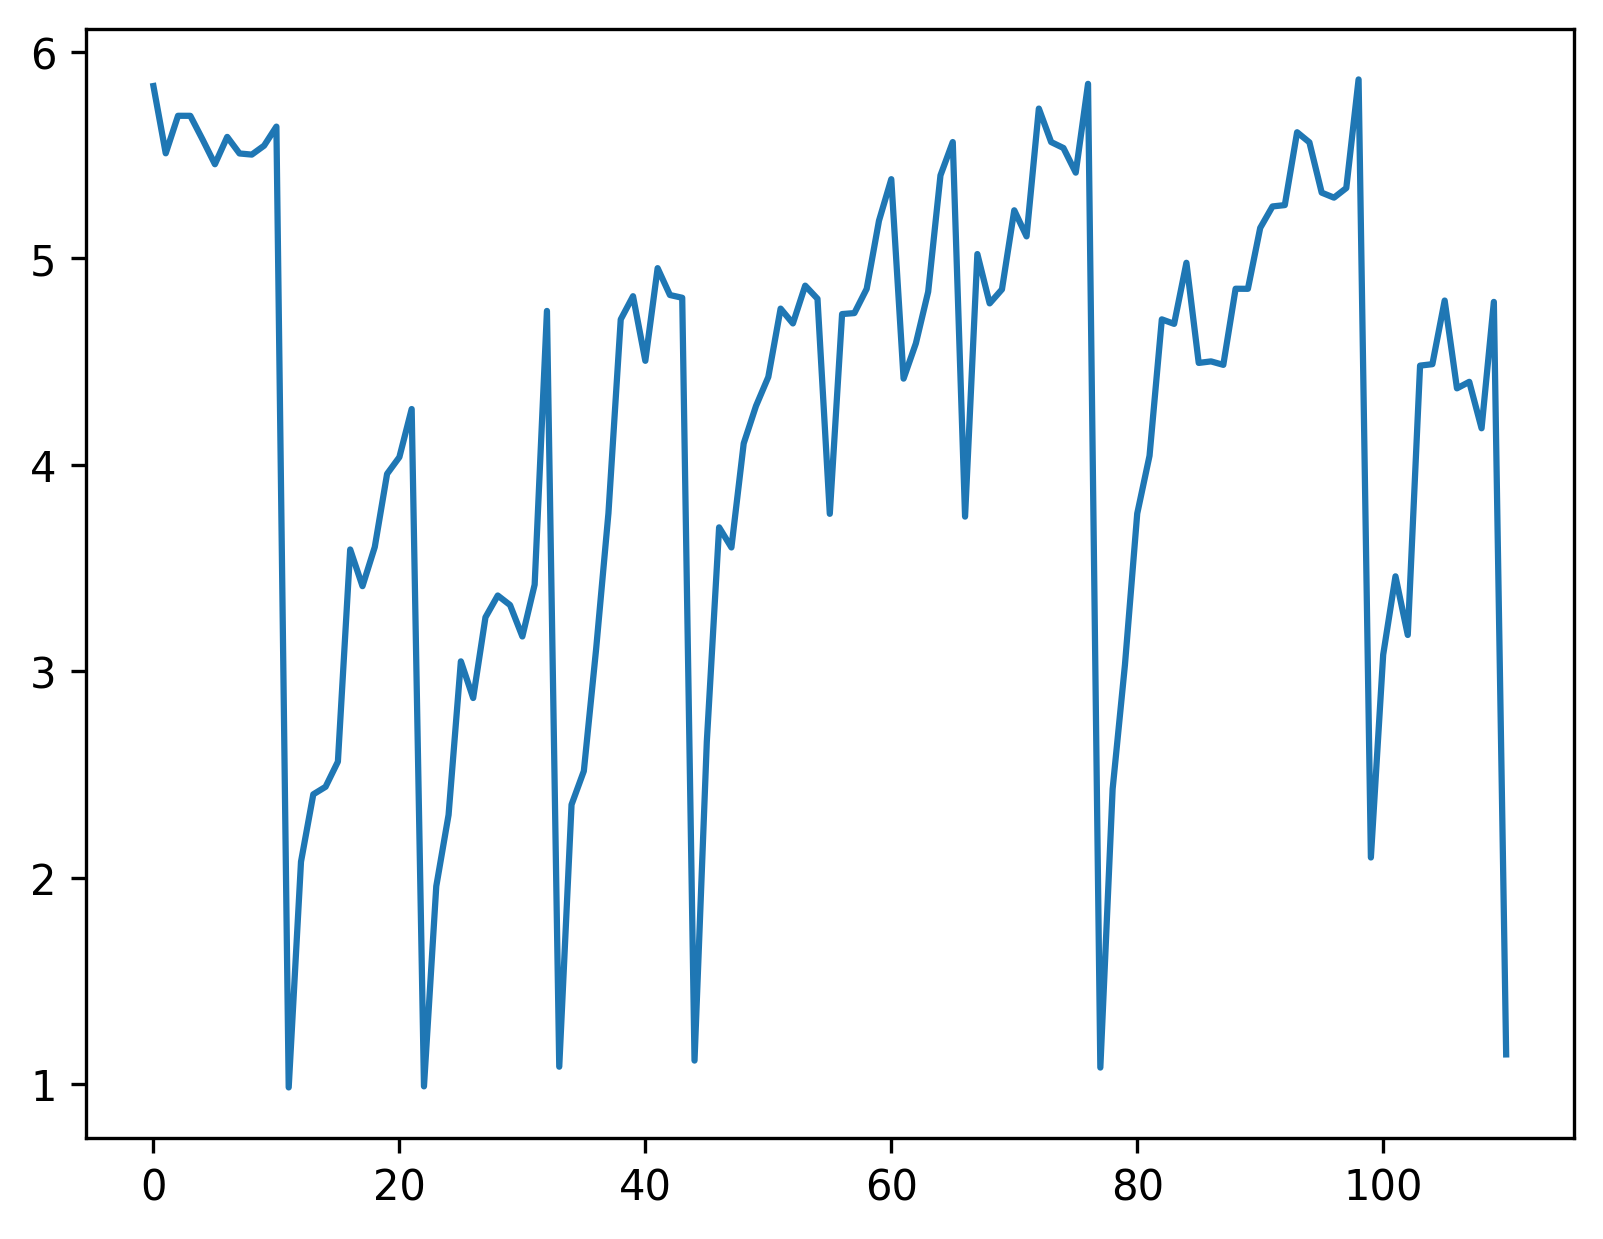

In [53]:
plot_hypervolume(lemoo._generation_history, ref_point=nadir)

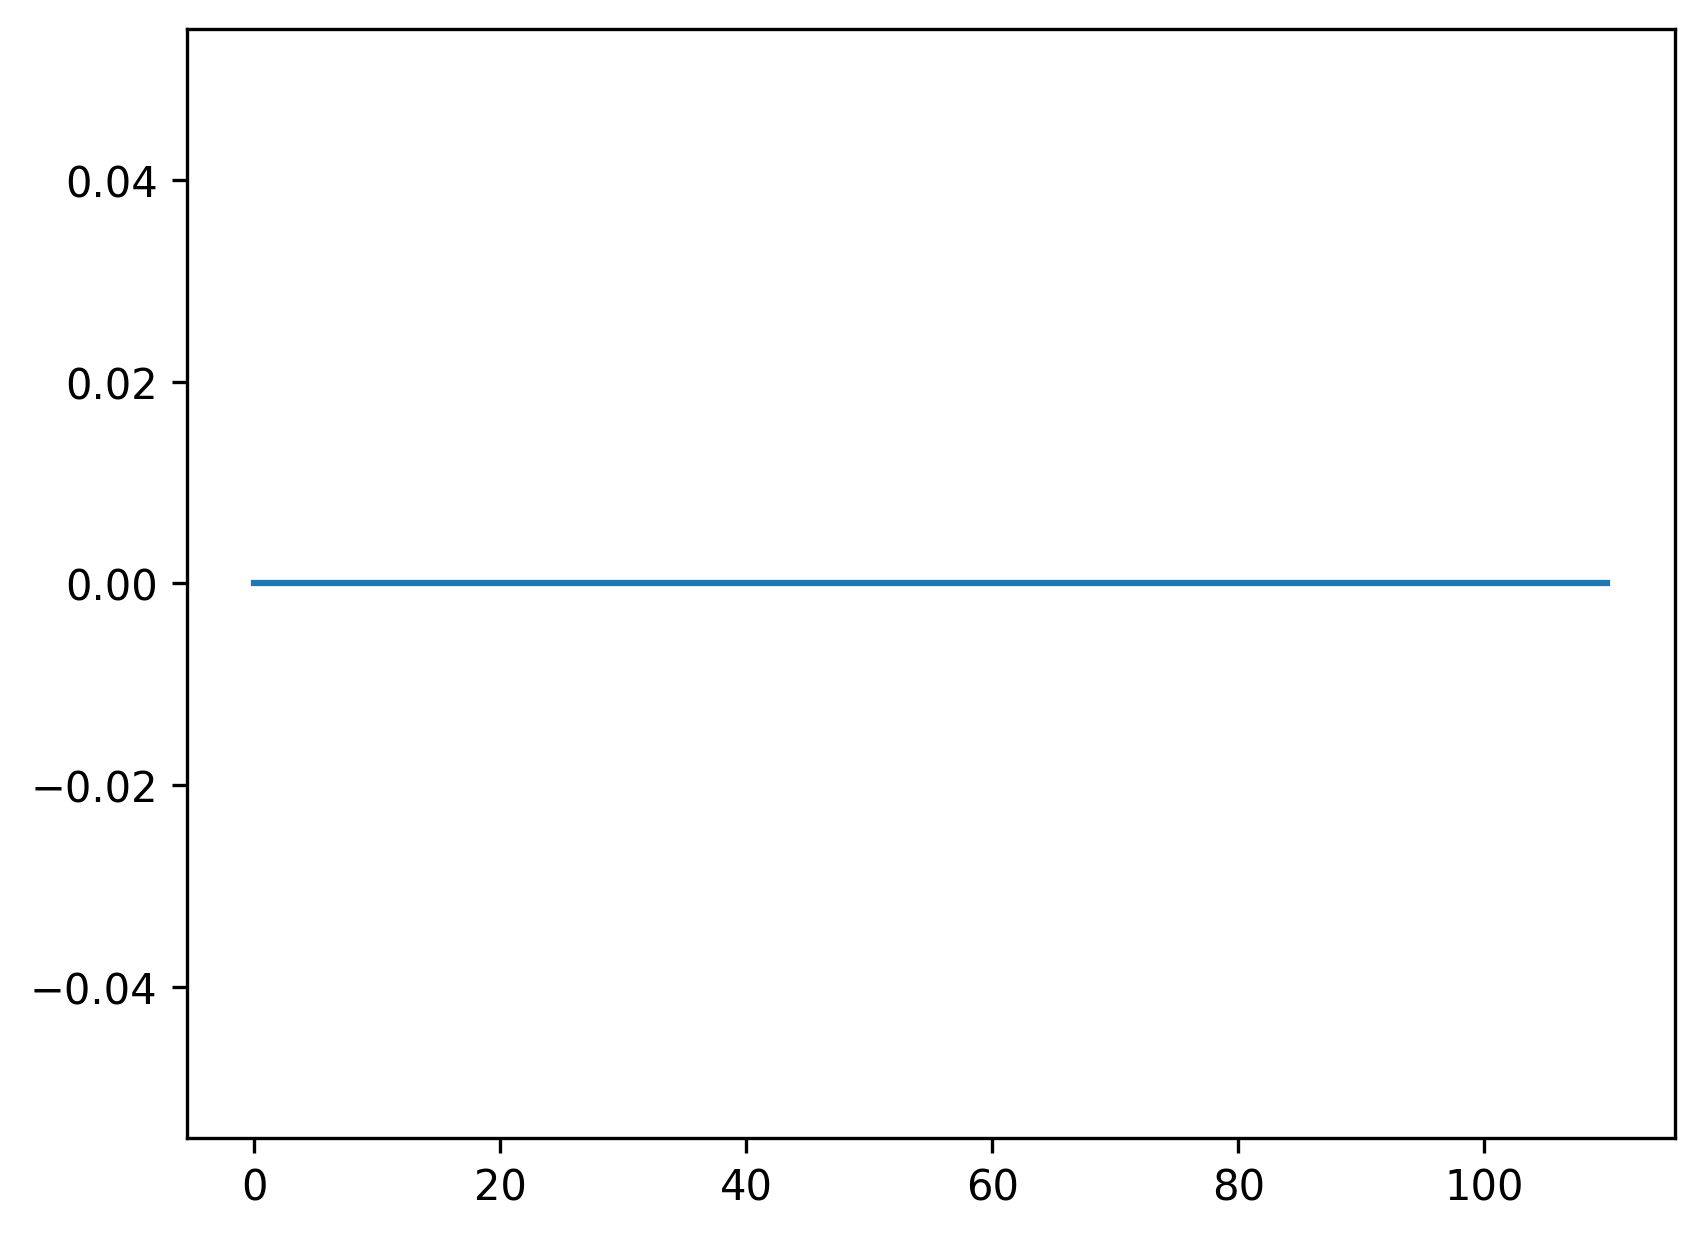

In [54]:
plot_best_fitnesses(lemoo._generation_history)

[Text(0.5, 0.875, 'X[1] <= 0.694\ngini = 0.5\nsamples = 8800\nvalue = [4400, 4400]'),
 Text(0.25, 0.625, 'X[1] <= 0.641\ngini = 0.133\nsamples = 2839\nvalue = [2636, 203]'),
 Text(0.125, 0.375, 'X[1] <= 0.598\ngini = 0.053\nsamples = 2366\nvalue = [2302, 64]'),
 Text(0.0625, 0.125, 'gini = 0.021\nsamples = 2047\nvalue = [2025, 22]'),
 Text(0.1875, 0.125, 'gini = 0.229\nsamples = 319\nvalue = [277, 42]'),
 Text(0.375, 0.375, 'X[0] <= 0.996\ngini = 0.415\nsamples = 473\nvalue = [334, 139]'),
 Text(0.3125, 0.125, 'gini = 0.462\nsamples = 353\nvalue = [225, 128]'),
 Text(0.4375, 0.125, 'gini = 0.167\nsamples = 120\nvalue = [109, 11]'),
 Text(0.75, 0.625, 'X[0] <= 0.73\ngini = 0.417\nsamples = 5961\nvalue = [1764, 4197]'),
 Text(0.625, 0.375, 'X[0] <= 0.461\ngini = 0.462\nsamples = 737\nvalue = [470, 267]'),
 Text(0.5625, 0.125, 'gini = 0.223\nsamples = 164\nvalue = [143, 21]'),
 Text(0.6875, 0.125, 'gini = 0.49\nsamples = 573\nvalue = [327, 246]'),
 Text(0.875, 0.375, 'X[0] <= 0.984\ngini 

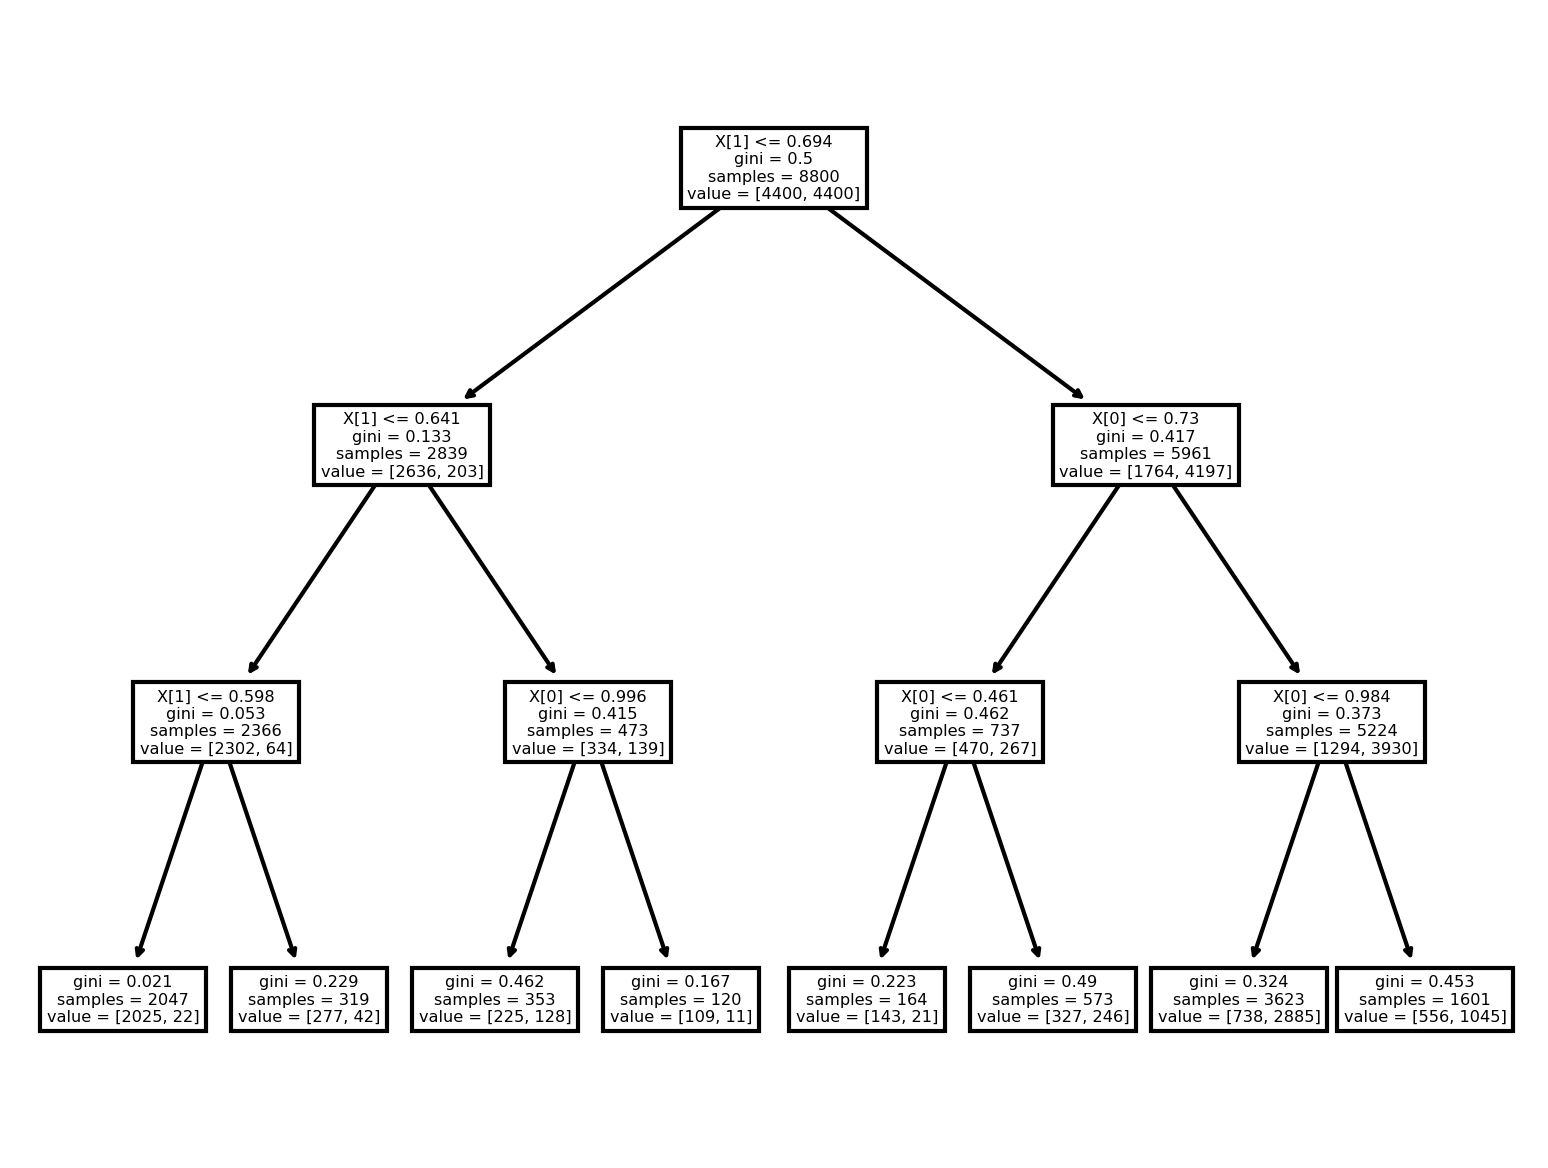

In [55]:
# print(lemoo.current_ml_model)
tree.plot_tree(lemoo.current_ml_model)

In [56]:
problem.evaluate(lemoo._generation_history[-1].individuals[0]).objectives

array([[-5.24464501, -3.10025499, -7.34649488,  1.75129002,  0.20786071]])

In [57]:
ref_point

array([-5.  , -3.1 , -4.4 ,  4.2 ,  0.15])

In [58]:
lemoo._generation_history[-1]

PastGeneration(individuals=array([[0.51746476, 0.85786071],
       [0.99771908, 0.89941254],
       [0.99111303, 0.77917902],
       [0.99237502, 0.87649532],
       [0.9970268 , 0.85094745],
       [0.98412294, 0.79112216],
       [0.98891797, 0.77601147],
       [0.99908483, 0.90030494],
       [0.99186163, 0.79260504],
       [0.99122037, 0.80496792],
       [0.99861176, 0.81463868],
       [0.98652682, 0.81279321],
       [0.9990726 , 0.9841605 ],
       [0.99757211, 0.78211387],
       [0.98918666, 0.97020269],
       [0.99987818, 0.91434038],
       [0.98912937, 0.84464576],
       [0.99364812, 0.87464306],
       [0.99256038, 0.90853555],
       [0.98405787, 0.95180264],
       [0.98621055, 0.88224894],
       [0.9932051 , 0.75706186],
       [0.9864887 , 0.90833547],
       [0.99327546, 0.95322923],
       [0.9888209 , 0.7790639 ],
       [0.99565839, 0.82817205],
       [0.99030225, 0.98300975],
       [0.98514987, 0.93115301],
       [0.98982284, 0.81134309],
       [0.987871